

# Importing all necessary libraries

In [40]:
import pandas as pd 
import numpy as np
import os
from keras import backend as K
from keras.preprocessing.image import load_img, save_img, img_to_array
import matplotlib.pyplot as plt
from keras.applications import vgg19
from keras.models import Model
#from keras import optimizers
from scipy.optimize import fmin_l_bfgs_b

## Loading the path for Base Content Image and the Style image respectively

In [41]:
base_image_path="/kaggle/input/image-classification/images/images/travel and  adventure/Places365_val_00005752.jpg"
style_image_path="/kaggle/input/best-artworks-of-all-time/images/images/Alfred_Sisley/Alfred_Sisley_101.jpg"

In [42]:
# dimensions of the generated picture.
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

## This function is used to Preprocess the image with help of VGG19.
**VGG19** is a model, with weights pre-trained on **ImageNet**.**ImageNet**, is a dataset of over 15 millions labeled high-resolution images with around 22,000 categories. ILSVRC uses a subset of ImageNet of around 1000 images in each of 1000 categories. In all, there are roughly 1.3 million training images, 50,000 validation images and 100,000 testing images.

In [43]:
def preprocess_image(image_path):
    from keras.applications import vgg19
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

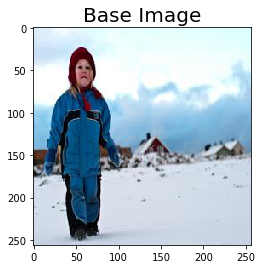

In [44]:
plt.figure()
plt.title("Base Image",fontsize=20)
img1 = load_img(base_image_path)
plt.imshow(img1)

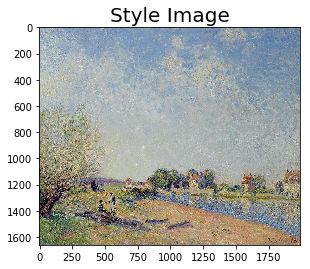

In [45]:
plt.figure()
plt.title("Style Image",fontsize=20)
img1 = load_img(style_image_path)
plt.imshow(img1)

In [46]:
# get tensor representations of our images

base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_image_path))

In [47]:
K.image_data_format()

'channels_last'

### This will contain our generated image

The below code provided is setting up a placeholder for the generated image based on the data format used by Keras.
Explanation:If input shape is (255,255,3) then:
K.image_data_format() returns the default image data format convention used by Keras.
If the data format is 'channels_first', it means that the color channels are the first dimension of the input shape.
If the data format is 'channels_last', it means that the color channels are the last dimension of the input shape.
Based on the data format, the code initializes a placeholder for the combination image.

In [48]:
# This will contain our generated image
if K.image_data_format() == 'channels_first':
    combination_image = K.placeholder((1,3,img_nrows, img_ncols))
else:
    combination_image = K.placeholder((1,img_nrows, img_ncols,3))

In [49]:
# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image
                              ], axis=0)

## Building the VGG19 model

In [50]:
# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
from keras.applications.vgg19 import VGG19
vgg19_weights = '../input/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
model = VGG19(input_tensor=input_tensor,
              include_top = False,
              weights=vgg19_weights)
#model = vgg19.VGG19(input_tensor=input_tensor,
#                    weights='imagenet', include_top=False)
print('Model loaded.')


Model loaded.


### Athough Vgg19 is basically used for Classification purpose, but here our objective is not to classify rather our objective is to transform a image, so we do not need all the layers of vgg19, we have specially excluded those layers which are used for classification.

In [51]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1',
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [52]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
print(outputs_dict['block5_conv2'])

Tensor("block5_conv2_1/Relu:0", shape=(3, 25, 25, 512), dtype=float32)


## The content Loss
Given a chosen content layer **l**, the content loss is defined as the Mean Squared Error between the feature map **F** of our content image **C** and the feature map **P** of our generated image **Y**.
![Coontent Loss](https://cdn-images-1.medium.com/max/800/1*1YfGhmzBw7EK3e8CRpZbuA.png)

In [53]:
# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image
def get_content_loss(base_content, target):
    return K.sum(K.square(target - base_content))

## The Style Loss
To do this at first we need to, calculate the **Gram-matrix**(a matrix comprising of correlated features) for the tensors output by the style-layers. The Gram-matrix is essentially just a matrix of dot-products for the vectors of the feature activations of a style-layer.<br><br>
If an entry in the Gram-matrix has a value close to zero then it means the two features in the given layer do not activate simultaneously for the given style-image. And vice versa, if an entry in the Gram-matrix has a large value, then it means the two features do activate simultaneously for the given style-image. We will then try and create a mixed-image that replicates this activation pattern of the style-image.
If the feature map is a matrix **F**, then each entry in the Gram matrix **G** can be given by:
![Gram Matrix](https://cdn-images-1.medium.com/max/800/1*5xx9KmhVb59Mxe_buOwHBA.png)
The loss function for style is quite similar to out content loss, except that we calculate the Mean Squared Error for the Gram-matrices instead of the raw tensor-outputs from the layers.
![Style loss](https://cdn-images-1.medium.com/max/800/1*PuYveCM2BlgFfjUCr6I_Ng.png)

In [54]:
import tensorflow as tf
# the gram matrix of an image tensor (feature-wise outer product)
def gram_matrix(input_tensor):
    assert K.ndim(input_tensor)==3
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram

def get_style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows*img_ncols
    return K.sum(K.square(S - C))
    

In [55]:
content_weight=0.025 
style_weight=1.0
# combine these loss functions into a single scalar
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
print('Layer Feature for Content Layers :: '+str(layer_features))
print('Base Image Feature :: '+str(base_image_features))
print('Combination Image Feature for Content Layers:: '+str(combination_features)+'\n')
loss += content_weight * get_content_loss(base_image_features,
                                      combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    print('Layer Feature for Style Layers :: '+str(layer_features))
    print('Style Image Feature :: '+str(style_reference_features))
    print('Combination Image Feature for Style Layers:: '+str(combination_features)+'\n')
    sl = get_style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl


Layer Feature for Content Layers :: Tensor("block5_conv2_1/Relu:0", shape=(3, 25, 25, 512), dtype=float32)
Base Image Feature :: Tensor("strided_slice_22:0", shape=(25, 25, 512), dtype=float32)
Combination Image Feature for Content Layers:: Tensor("strided_slice_23:0", shape=(25, 25, 512), dtype=float32)

Layer Feature for Style Layers :: Tensor("block1_conv1_1/Relu:0", shape=(3, 400, 400, 64), dtype=float32)
Style Image Feature :: Tensor("strided_slice_24:0", shape=(400, 400, 64), dtype=float32)
Combination Image Feature for Style Layers:: Tensor("strided_slice_25:0", shape=(400, 400, 64), dtype=float32)

Layer Feature for Style Layers :: Tensor("block2_conv1_1/Relu:0", shape=(3, 200, 200, 128), dtype=float32)
Style Image Feature :: Tensor("strided_slice_28:0", shape=(200, 200, 128), dtype=float32)
Combination Image Feature for Style Layers:: Tensor("strided_slice_29:0", shape=(200, 200, 128), dtype=float32)

Layer Feature for Style Layers :: Tensor("block3_conv1_1/Relu:0", shape=(3, 

### Features are extracted from each layer in style layers and content layers and their overall loss is calculated from it

### This deprocess_image function is used return the original format of the Final image  after transformation which could be easily read and displayed by Matplotlib.

In [56]:
def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

### Calculation of gradient with respect to loss..

In [57]:
# get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)
grads

[<tf.Tensor 'gradients_1/concat_1_grad/Slice_2:0' shape=(1, 400, 400, 3) dtype=float32>]

In [58]:
outputs = [loss]
if isinstance(grads, (list,tuple)):
    outputs += grads
else:
    outputs.append(grads)
f_outputs = K.function([combination_image], outputs)
f_outputs

In [59]:
# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# we can also use ADAM optimization
# so as to minimize the neural style loss
x_opt = preprocess_image(base_image_path)

In [60]:
def eval_loss_and_grads(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, img_nrows, img_ncols))
    else:
        x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values


### The purpose of below Evaluator class is to avoid the error 'numpy.ndarray' object is not callable error with optimize.minimize while running the L-BFGS optimizer for loss minimization.
### We can pass the function itself to minimize, instead of a evaluated value. 

In [61]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [62]:
evaluator = Evaluator()

### In this segment we run the code upto a given iteration.

In [63]:
iterations=300
# Store our best result
best_loss, best_img = float('inf'), None
for i in range(iterations):
    print('Start of iteration', i)
    x_opt, min_val, info= fmin_l_bfgs_b(evaluator.loss, 
                                        x_opt.flatten(), 
                                        fprime=evaluator.grads,
                                        maxfun=20,
                                        disp=True,
                                       )
    print('Current loss value:', min_val)
    if min_val < best_loss:
        # Update best loss and best image from total loss. 
        best_loss = min_val
        best_img = x_opt.copy()

Start of iteration 0
Current loss value: 1.0788212e+21
Start of iteration 1
Current loss value: 5.3454195e+20
Start of iteration 2
Current loss value: 3.543313e+20
Start of iteration 3
Current loss value: 2.6052149e+20
Start of iteration 4
Current loss value: 2.0944611e+20
Start of iteration 5
Current loss value: 1.6790406e+20
Start of iteration 6
Current loss value: 1.4142462e+20
Start of iteration 7
Current loss value: 1.20397895e+20
Start of iteration 8
Current loss value: 1.0601158e+20
Start of iteration 9
Current loss value: 9.188748e+19
Start of iteration 10
Current loss value: 8.222774e+19
Start of iteration 11
Current loss value: 7.265548e+19
Start of iteration 12
Current loss value: 6.5508353e+19
Start of iteration 13
Current loss value: 5.775592e+19
Start of iteration 14
Current loss value: 5.3030145e+19
Start of iteration 15
Current loss value: 4.9686486e+19
Start of iteration 16
Current loss value: 4.6723404e+19
Start of iteration 17
Current loss value: 4.415713e+19
Start o

**The Final Image**

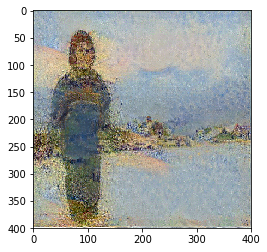

In [64]:
# save current generated image
imgx = deprocess_image(best_img.copy())
plt.imshow(imgx)

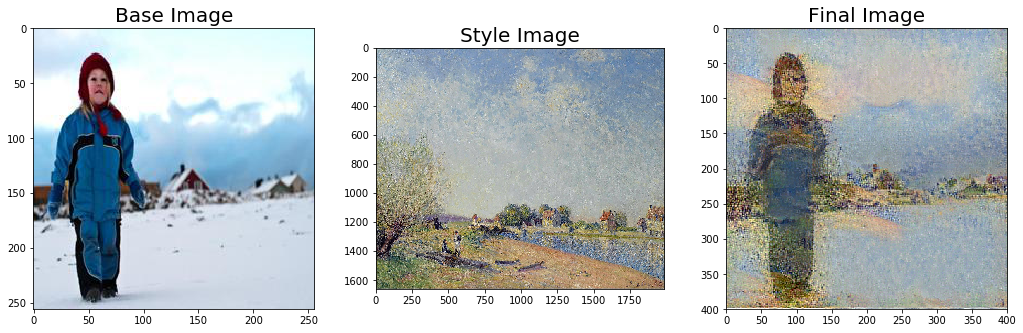

In [65]:
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
plt.title("Base Image",fontsize=20)
img_base = load_img(base_image_path)
plt.imshow(img_base)

plt.subplot(5,5,1+1)
plt.title("Style Image",fontsize=20)
img_style = load_img(style_image_path)
plt.imshow(img_style)

plt.subplot(5,5,1+2)
plt.title("Final Image",fontsize=20)
plt.imshow(imgx)

# Conclusion

* Our model can be improved through icreasing the number of iteration, or by trying out a different syle transfer algorithm which could preseve the edges of the base image, or by trying out with different optimizer to minimize gradient and loss.